# Practica 2: Mejoramiento de la imagen

## 1. Objetivos:
El alumno:
* Aprendera a mejorar la imagen de acuerdo a las modificaciones que se le realizan originalmente.
* Entendera aumentar las caracteristicas de contraste, perfilado que apoyen a una mejor medicion.

## 2. Introduccion
En el proceso de adquisicion de una imagen, esta se puede contaminar con distintos tipos de ruido: gaussiano, impulsivo (sal y pimienta), frecuencial, multiplicativo, etc. Para poder eliminar el ruido se debe hacer un filtrado de la imagen, donde dependiendo del tipo de ruido es el filtro que debe ser usado.  

En esta practica se cuenta con una imagen que se obtuvo mediante una resonancia magnetica y se puede observar el cerebro de un paciente. A esta imagen se le a;adio ruido impulsivo y debemos restaurarla mediante el uso del filtro mas apropiado que es el kernel de mediana. 



## 3. Desarrollo

In [421]:
import cv2
import sklearn
import skimage.io
import numpy as np
from scipy import ndimage
from scipy import signal
import matplotlib.pyplot as plt
% matplotlib inline

 ## Parte A:
 1. Restauracion del nivel de contraste
 2. Eliminar ruido sal y pimienta

In [422]:
# Leer imagen original
imOriginal = cv2.imread('midbrain.png', 0)

In [423]:
# Leer imagen degradada
imDegraded = cv2.imread('midbrainDegraded2.png', 0)
# Normalizar imagen en el intervalo [0, 1]
imDegraded = cv2.normalize(imDegraded.astype('float'), None, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)

In [424]:
# Inicializacion de imagen restaurada
im = np.zeros((imDegraded.shape[0], imDegraded.shape[1]))

In [425]:
# Revertir la alteracion del contraste
for i in range(imDegraded.shape[0]):
    for j in range(imDegraded.shape[1]):
        newpixel = imDegraded[i,j]
        if newpixel < 0.4:
            oldpixel = 1.6*newpixel
        elif newpixel > 0.4 and newpixel < 0.6:
            oldpixel = newpixel
        else:
            oldpixel = 8/3*newpixel - 1
        im[i,j] = oldpixel

In [426]:
# Eliminar ruido sal y pimienta con filtro de mediana
im = ndimage.median_filter(im, 5)

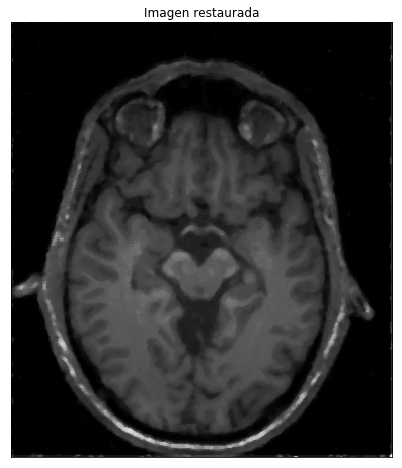

In [427]:
fig = plt.figure(figsize=(8,8))
plt.title('Imagen restaurada')
plt.imshow(im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## Parte B:
1. Perfilado de la imagen
2. Normalizacion 

El perfilado de la imagen consiste en sumar a la imagen original el laplaciano multiplicado por un factor de ponderacion k.
De esta forma se consigue resaltar los bordes de la imagen, lo cual es util en tareas de segmentacion. 

Debido a que el operador Laplaciano es sensible al ruido, usaremos el filtro Laplaciano de una Gaussiana (LoG) el cual suaviza la imagen con una Gaussiana con la desviacion estandar especificada como argumento (para eliminar el ruido) y posteriormente se aplica el operador Laplaciano.  

In [428]:
# Aplicar el filtro laplaciano de gaussiana
imLap = ndimage.gaussian_laplace(im, sigma=6)

In [429]:
# Realizar perfilado de la imagen
k = 1
imNew = im + k*imLap

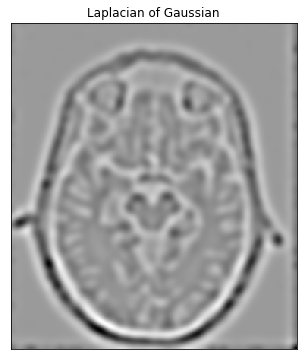

In [430]:
fig2 = plt.figure(figsize=(6,6))
plt.imshow(imLap, cmap='gray')
plt.title('Laplacian of Gaussian')
plt.xticks([])
plt.yticks([])
plt.show()

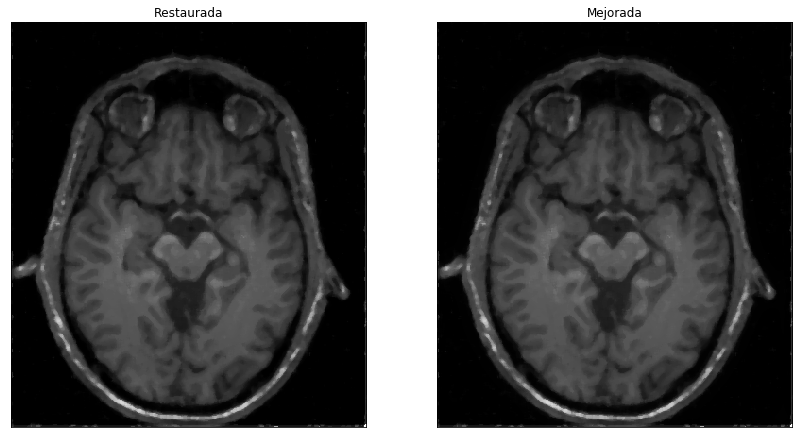

In [431]:
fig3 = plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Restaurada')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(imNew, cmap='gray')
plt.title('Mejorada')
plt.xticks([])
plt.yticks([])
plt.show()

In [432]:
imMin = np.min(imOriginal)
imMax = np.max(imOriginal)

print('Valor minimo = ', imMin)
print('Valor maximo = ', imMax)

Valor minimo =  0
Valor maximo =  255


Los niveles de gris de la imagen original son del [0, 255], mientras que los niveles de gris de la imagen restaurada estan en el rango [0, 1]. Usando el comando cv2.normalize() se realiza un mapeo al rango de la imagen original.

In [433]:
imNew = cv2.normalize(imNew, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
imNew = imNew.astype(np.uint8)
im = cv2.normalize(im, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
im = im.astype(np.uint8)

In [434]:
# Verificamos que el tipo de dato de la imagen sea un entero de 8 bits
imNew.dtype

dtype('uint8')

## Parte C
Separar el mesencefalo del resto de la imagen.
Para lograr esta separacion, usare 2 algoritmos:
1. Segmentacion usando thresholding, usando como parametros el limite inferior y superior del nivel de gris.
2. Segmentacion usando watershed 

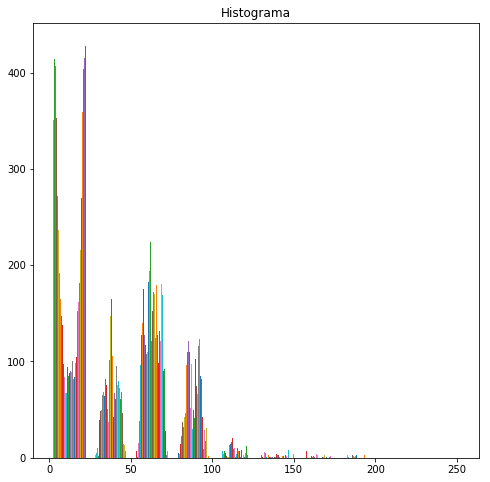

In [435]:
fig4 = plt.figure(figsize=(8,8))
plt.hist(imNew)
plt.title('Histograma')
plt.show()

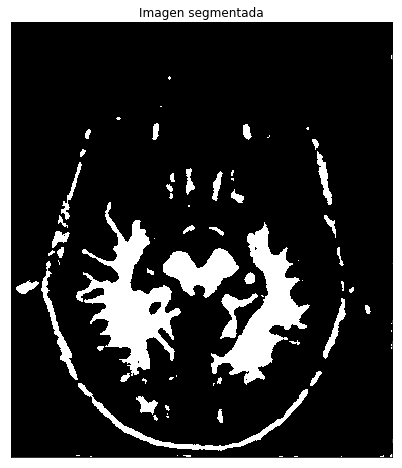

In [436]:
# Segmentacion usando umbral, basado en el histograma
_,imSeg = cv2.threshold(imNew,81,100,cv2.THRESH_BINARY)

plt.figure(figsize=(8,8))
plt.imshow(imSeg, cmap='gray')
plt.title('Imagen segmentada')
plt.xticks([])
plt.yticks([])
plt.show()

In [437]:
imSeg.shape

(430, 377)

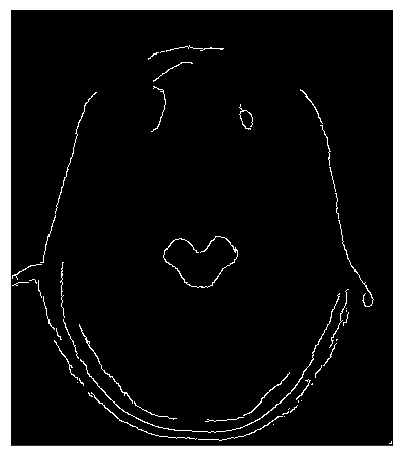

In [438]:
# Encontrar los bordes usando el detector canny
from skimage import feature 
imEdges = skimage.feature.canny(imNew, sigma=3.5)

plt.figure(figsize=(8,8))
plt.imshow(imEdges, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

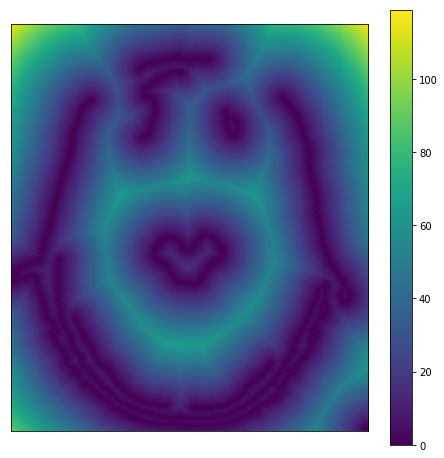

In [439]:
# Calcular la distancia euclidiana usando los bordes 
from scipy.ndimage import distance_transform_edt
imDist = distance_transform_edt(~imEdges)

plt.figure(figsize=(8,8))
plt.imshow(imDist)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

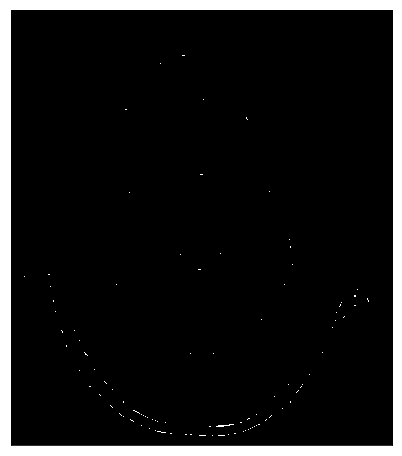

In [440]:
# Encontrar los puntos maximos de la funcion de distancia
local_max = feature.peak_local_max(imDist, indices=False, min_distance=5)

plt.figure(figsize=(8,8))
plt.imshow(local_max, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

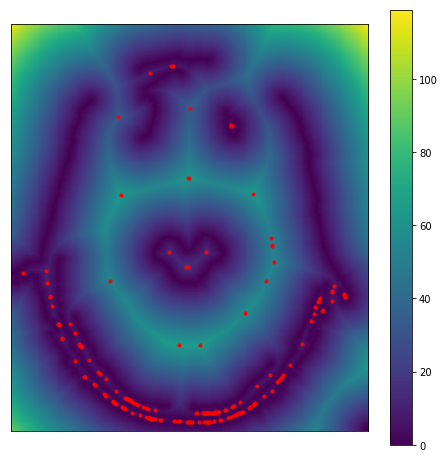

In [441]:
# Indices de los maximos locales 
# A partir de estos puntos se comenzara el relleno del agua
peak_idx = feature.peak_local_max(imDist, indices=True, min_distance=5)

plt.figure(figsize=(8,8))
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(imDist)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [442]:
# Etiquetado de cada uno de los maximos locales usando los indices calculados
# es usado por el algoritmo de watershed para ir rellenando de agua las regiones 
# indicadas por los indices
from skimage import measure

markers = measure.label(local_max)

C:\Users\sjukdom\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


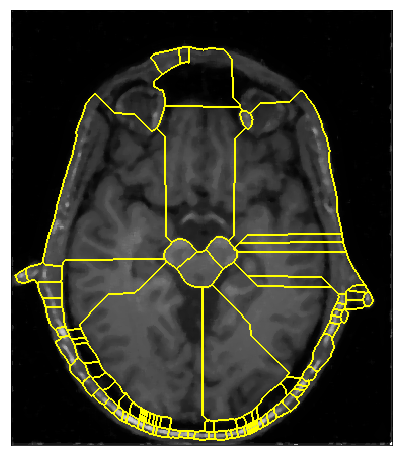

In [443]:
# Aplicar el algoritmo de watershed
# el mapa de distancias es invertido
from skimage import morphology, segmentation

labels = morphology.watershed(-imDist, markers)

plt.figure(figsize=(8,8))
plt.imshow(segmentation.mark_boundaries(imNew, labels))
plt.xticks([])
plt.yticks([])
plt.show()

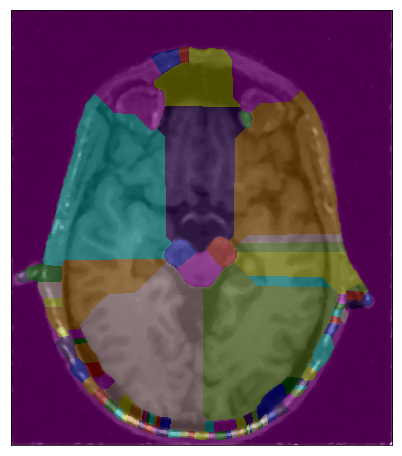

In [444]:
from skimage import color

plt.figure(figsize=(8,8))
plt.imshow(color.label2rgb(labels, image=imNew))
plt.xticks([])
plt.yticks([])
plt.show()

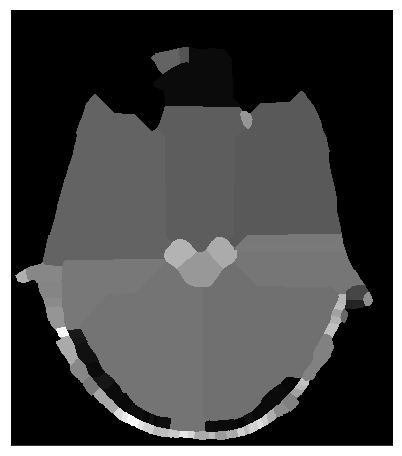

In [445]:
plt.figure(figsize=(8,8))
plt.imshow(color.label2rgb(labels, image=imNew, kind='avg'), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [446]:
regions = measure.regionprops(labels, intensity_image=imNew)

In [447]:
region_means = [r.mean_intensity for r in regions]

In [448]:
# Aplicar el algoritmo de agrupamiento k-medias
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)

region_means = np.array(region_means).reshape(-1, 1)

model.fit(np.array(region_means).reshape(-1, 1))

print(model.cluster_centers_)

[[ 66.77985884]
 [ 13.71611394]
 [ 97.8413587 ]
 [121.94100186]]


In [449]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 3, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 0, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1,
       3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3,
       2, 3, 3, 2, 2, 2, 2])

In [450]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg

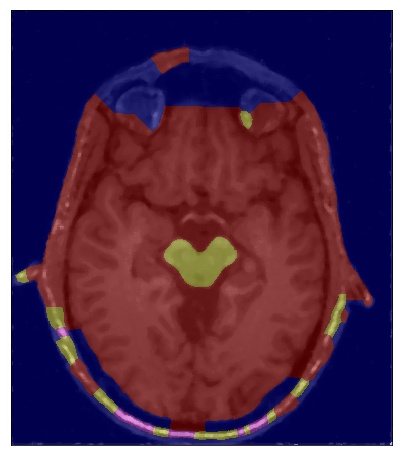

In [479]:
plt.figure(figsize=(8,8))
plt.imshow(color.label2rgb(classified_labels, image=imNew))
plt.xticks([])
plt.yticks([])
plt.show()

In [467]:
imMask = np.zeros((430, 377))
for i in range(430):
    for j in range(377):
        if classified_labels[i, j] == 2:
            imMask[i, j] = 1

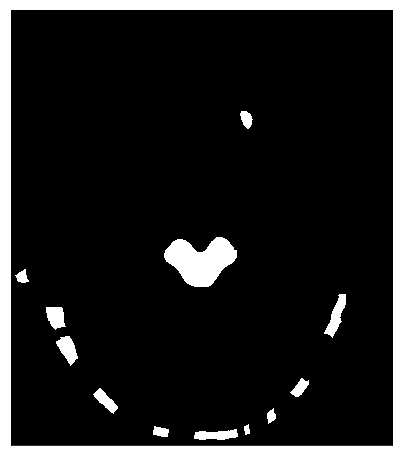

In [480]:
plt.figure(figsize=(8,8))
plt.imshow(imMask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

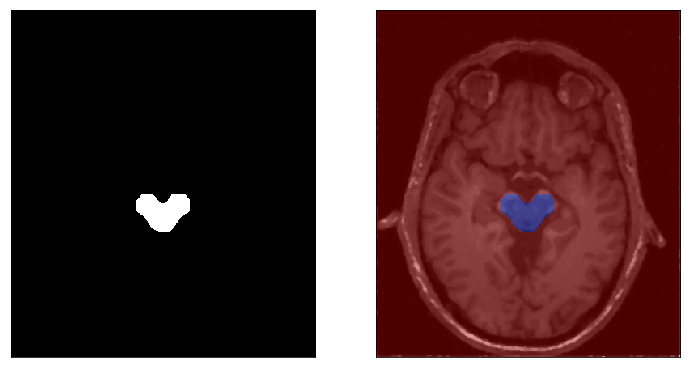

In [481]:
# Aplicar transformacion morfologica
kernel = np.ones((14,14),np.uint8)

midBrains = cv2.morphologyEx(imMask, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(midBrains, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(color.label2rgb(midBrains, image=imNew))
plt.xticks([])
plt.yticks([])
plt.show()

## Parte D
Medir el area que ocupa el mesencefalo.

In [470]:
midbrain_px = np.sum(midBrains)

print('pixeles que ocupa el mesencefalo = ', midbrain_px)

pixeles que ocupa el mesencefalo =  2166.0


In [482]:
midbrain_area = midbrain_px * 0.04 * 0.04
print('area del mesencefalo = ', midbrain_area)

area del mesencefalo =  3.4656000000000002


## Conclusiones
La manipulacion de la imagen del mesencefalo con ruido del tipo sal y pimienta fue filtrada con el kernel de media el cual es el optimo en esta situacion, se pudo verificar que la imagen mejoro notablemente.

El perfilado de la imagen permitio resaltar los bordes de la imagen usando el filtro laplaciano con lo que se facilito la tarea de encontrar los bordes mediante el detector canny. De esta forma se obtuvo el contorno del mesencefalo.

Una vez con la imagen que indica los bordes de la imagen, se calculo la transformacion de distancias de cada pixel con respecto a cada borde, asi se obtiene un mapa que indica la superficie de la imagen, util para realizar la segmentacion de la imagen con el algoritmo watershed.

Para separar al mesencefalo del fondo, el algoritmo watershed nos permitio encontrar las fronteras de la imagen original que fueron agrupadas en k = 4 clusters usando el algoritmo k-means.

Finalmente, para calcular el area del mesencefalo se uso la mascara binaria, sumando los pixeles que son igual a 1 y multiplicandolos por la resolucion espacial de cada pixel.

## Referencias

algoritmo watershed:
https://www.youtube.com/watch?v=STnoJ3YCWus

algortimo kmeans:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

transformaciones mofologicas:
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops 